w的估计误差: tensor([-0.0004,  0.0004])
b的估计误差: tensor([-3.1948e-05])


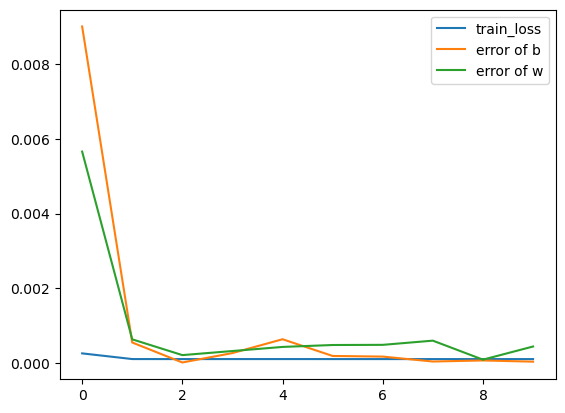

In [6]:
import torch
from torch import nn
from torch.utils import data
from matplotlib import pyplot as plt
lr = 0.03
num_epochs = 10
batch_size = 10

true_w = torch.tensor([2, -3.4])  # 定义w和b的实际值
true_b = 4.2

def synthetic_data(w, b, num_examples):
    # 生成 y = Xw + b + 噪声
    X = torch.normal(mean=0, std=1, size=(num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(mean=0, std=0.01, size=y.shape)
    return X, y.reshape((-1, 1))

def loader(data_arrays, batch_size, is_train = True): # 调用现有的API读取数据
    # 构造一个Pytorch数据迭代器
    dataset = data.TensorDataset(*data_arrays) # 将自己的数据载入API提供的数据集类
    return data.DataLoader(dataset, batch_size, shuffle=is_train) # 用数据集构造数据迭代器

features, labels = synthetic_data(true_w, true_b, 1000)
data_iter = loader((features, labels), batch_size, is_train=True)
net = nn.Sequential(
    nn.Linear(2, 1)
)  # 定义模型 Sequential将各个层连接起来

"""
如在构造nn.Linear时指定输入和输出尺寸一样,现在能直接访问参数以设定它们的初始值。
通过net[0]选择网络中的第一个图层,然后使用weight.data和bias.data方法访问参数。
还可以使用替换方法normal_和fill_来重写参数值。
"""
net[0].weight.data.normal_(mean=0, std=0.01)
net[0].bias.data.fill_(0)
train_loss_res = []
error_w_res = []
error_b_res = []
loss_function = nn.MSELoss() # 定义损失函数为均方误差
optimizer = torch.optim.SGD(params=net.parameters(), lr = lr) # 使用API提供的优化器

"""
训练：
在每个迭代周期里,将完整遍历一次数据集(train_data)不停地从中获取一个小批量的输入和相应的标签。
对于每一个小批量，会进行以下步骤:
• 通过调用net(X)生成预测并计算损失loss(前向传播)。
• 通过进行反向传播来计算梯度。
• 通过调用优化器来更新模型参数。
"""
for epoch in range((num_epochs)):
    for X, y in data_iter:
        train_loss = loss_function(net(X),y)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    with torch.no_grad():
        train_loss = loss_function(net(features),labels) # 优化一次后 计算现在的损失
        train_loss_res.append(train_loss.mean())
        error_w_res.append(torch.abs(true_w-net[0].weight.data).mean())
        error_b_res.append(torch.abs(true_b-net[0].bias.data).mean())
        print(f"epoch{epoch + 1}, train_loss = {train_loss}")
plt.plot([epoch for epoch in range(num_epochs)],train_loss_res, label="train_loss")
plt.plot([epoch for epoch in range(num_epochs)],error_b_res, label="error of b")
plt.plot([epoch for epoch in range(num_epochs)],error_w_res, label="error of w")
plt.legend()
w, b = net[0].weight.data, net[0].bias.data
print('w的估计误差:', true_w - w.reshape(true_w.shape))
print('b的估计误差:', true_b - b)